Possible issue encountered when converting Shape #1 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.


Contents of indices_df:
        Date      NDVI      SAVI       GCI             Shapefile  Backscatter
0 2022-06-07  0.551246  0.826811  1.892590  AgriculturalLand.shp          NaN
1 2022-06-18  0.258405  0.387581  0.797663  AgriculturalLand.shp          NaN
2 2022-06-25  0.041450  0.062173  0.139462  AgriculturalLand.shp          NaN
3 2022-06-28  0.417988  0.626929  1.224206  AgriculturalLand.shp          NaN
4 2022-06-30  0.479550  0.719268  1.485154  AgriculturalLand.shp          NaN
Contents of data_df:
        Date  Temperature  DewpointTemperature  Precipitation  WindSpeed
0 2022-06-01   283.745331           280.995255   2.317131e-05   4.368973
1 2022-06-01   283.644119           280.923111   0.000000e+00   3.455900
2 2022-06-01   283.391724           280.969757   0.000000e+00   2.316059
3 2022-06-01   282.835464           281.140518   0.000000e+00   1.527235
4 2022-06-01   282.791382           281.369995   8.568168e-07   1.471557
Contents of combined_df:
        Date      NDVI  

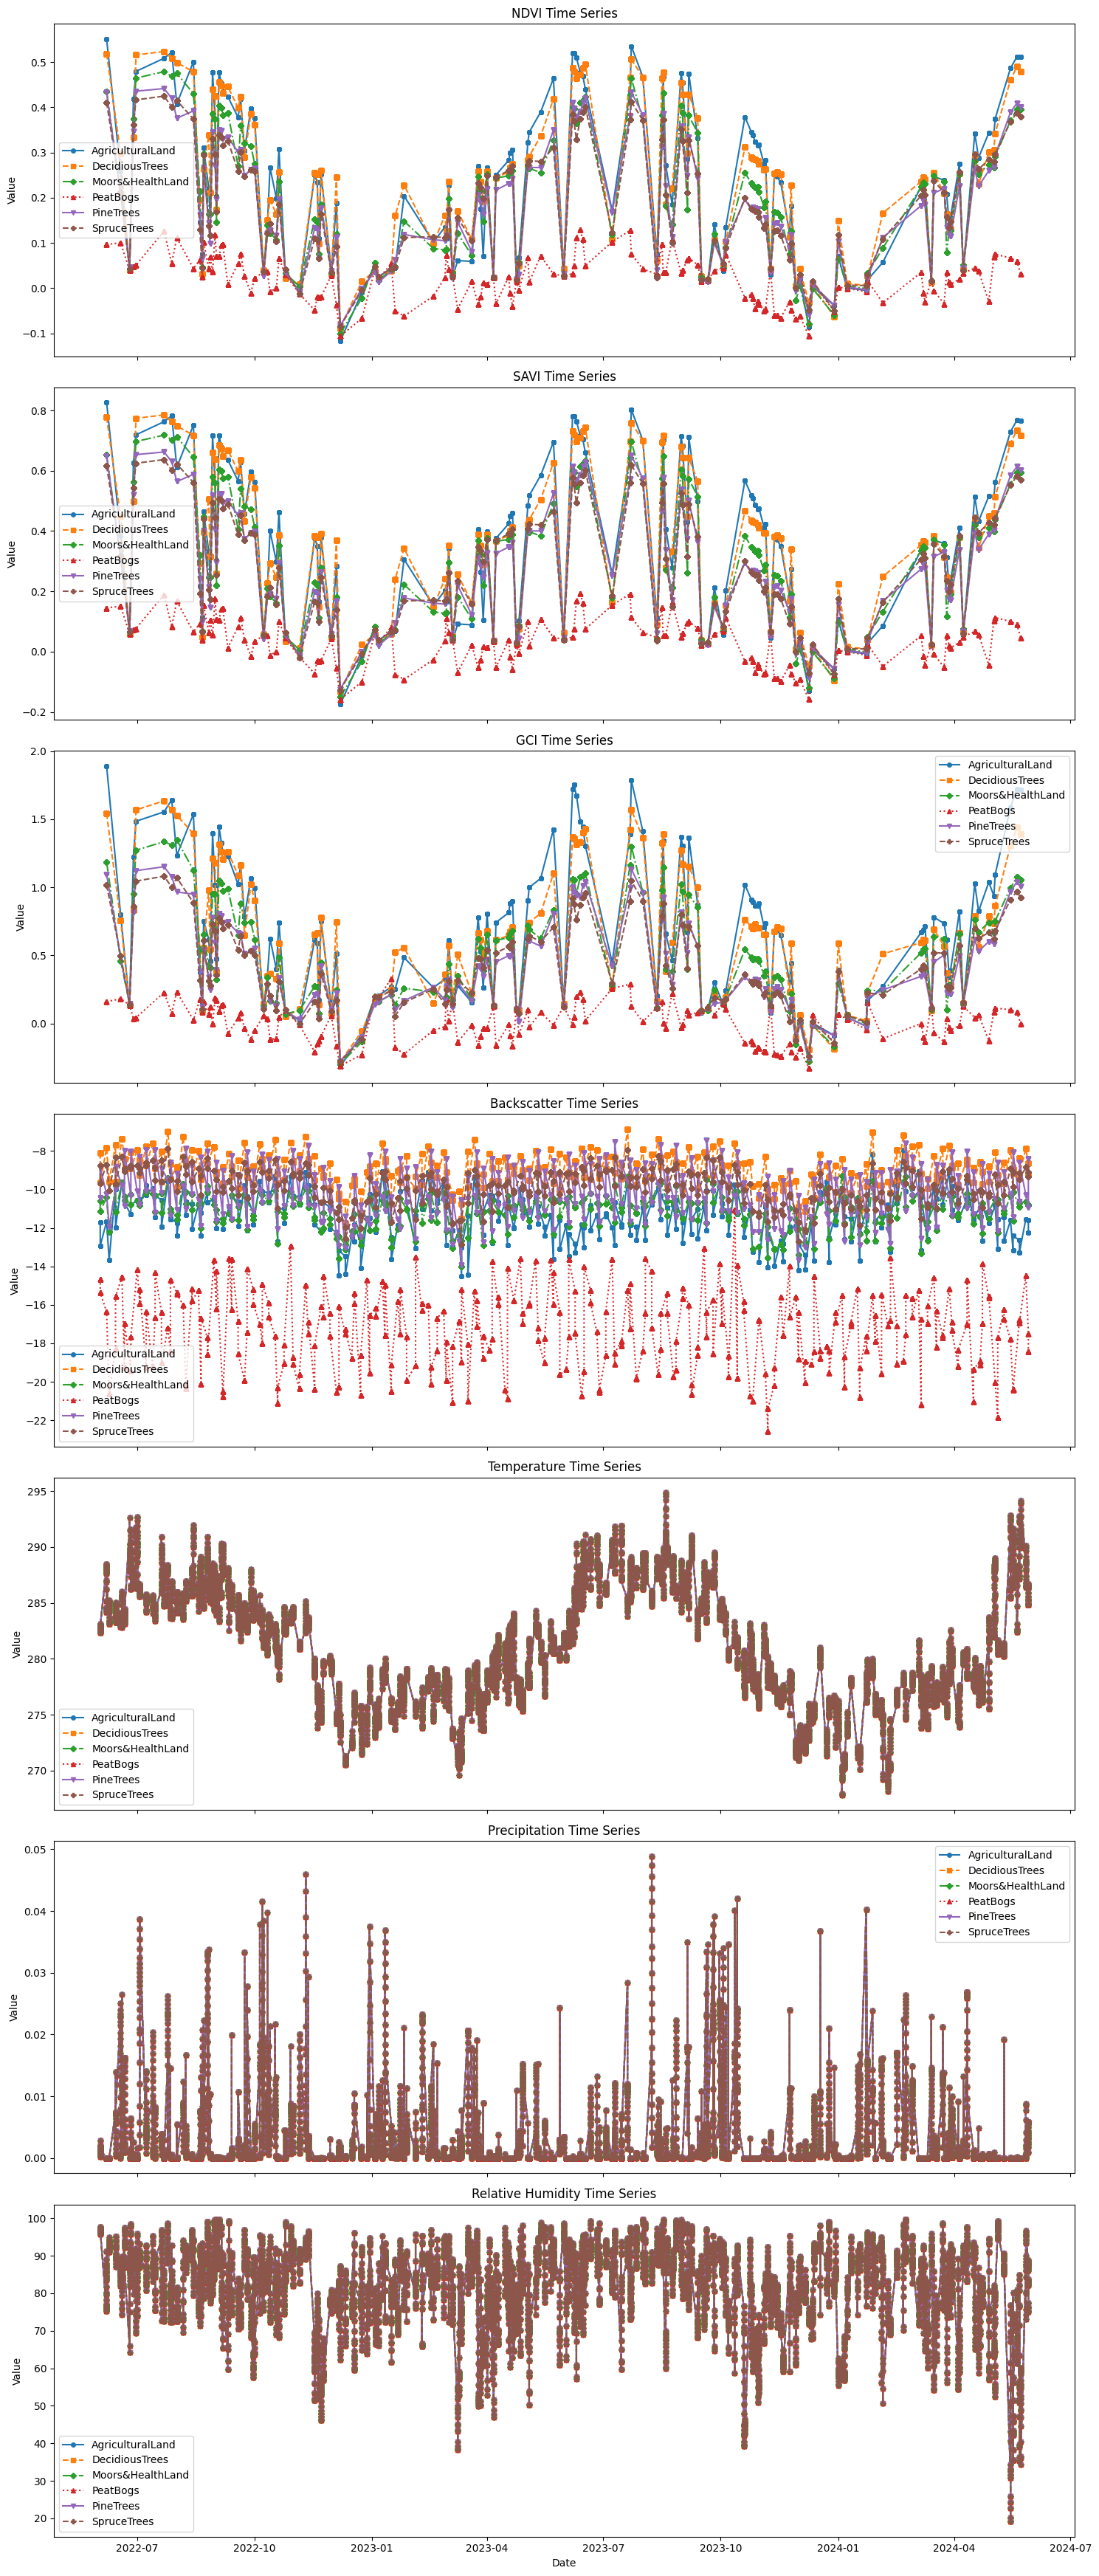

In [5]:
import geemap
import ee
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# Initialize the Earth Engine module.
ee.Initialize()

# Function to calculate relative humidity
def calculate_relative_humidity(temp, dewpoint_temp):
    return 100 - 5 * (temp - dewpoint_temp)

# Path to the folder containing the shapefiles.
shp_folder = 'Shapefiles/'

# List of shapefiles in the folder.
shapefiles = ['AgriculturalLand.shp', 'DecidiousTrees.shp', 'Moors&HealthLand.shp', 'PeatBogs.shp', 'PineTrees.shp', 'SpruceTrees.shp']

# Function to check if the shapefile exists
def shapefile_exists(path):
    return os.path.exists(path)

# DataFrame to store indices time series.
indices_df = pd.DataFrame()

# Define the date range.
start_date = '2022-06-01'
end_date = '2024-05-31'

# Process each shapefile.
for shp in shapefiles:
    shp_path = os.path.join(shp_folder, shp)
    
    if not shapefile_exists(shp_path):
        print(f"Shapefile {shp_path} does not exist.")
        continue

    # Load the shapefile.
    shapefile_fc = geemap.shp_to_ee(shp_path)
    
    if shapefile_fc is None:
        print(f"Could not load shapefile {shp_path}.")
        continue

    geometry = shapefile_fc.geometry()

    # Load Sentinel-2 image collection, filter by cloud cover, and sort by cloud cover percentage.
    s2_collection = (ee.ImageCollection('COPERNICUS/S2')
                     .filterDate(start_date, end_date)
                     .filterBounds(geometry)
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
                     .select(['B4', 'B8', 'B3'])
                     .map(calculate_indices))

    # Load Sentinel-1 image collection, filter by date and bounds.
    s1_collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filterDate(start_date, end_date)
                     .filterBounds(geometry)
                     .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                     .select('VV')
                     .map(calculate_backscatter))

    # Use an iterate function to get indices values over time.
    def accumulate_indices(image, list):
        date = image.get('date')
        ndvi_value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=10
        ).get('NDVI')
        savi_value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=10
        ).get('SAVI')
        gci_value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=10
        ).get('GCI')
        feature = ee.Feature(None, {'date': date, 'NDVI': ndvi_value, 'SAVI': savi_value, 'GCI': gci_value, 'shapefile': shp})
        return ee.List(list).add(feature)

    def accumulate_backscatter(image, list):
        date = image.get('date')
        backscatter_value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=10
        ).get('Backscatter')
        # Handle None values by replacing them with NaN
        if backscatter_value is None:
            backscatter_value = None
        feature = ee.Feature(None, {'date': date, 'Backscatter': backscatter_value, 'shapefile': shp})
        return ee.List(list).add(feature)

    initial_list = ee.List([])
    indices_time_series = ee.List(s2_collection.iterate(accumulate_indices, initial_list))
    backscatter_time_series = ee.List(s1_collection.iterate(accumulate_backscatter, initial_list))

    # Convert the lists to FeatureCollections
    indices_fc = ee.FeatureCollection(indices_time_series)
    backscatter_fc = ee.FeatureCollection(backscatter_time_series)

    # Get the indices values and dates
    indices_info = indices_fc.getInfo()
    backscatter_info = backscatter_fc.getInfo()

    for feature in indices_info['features']:
        date = feature['properties']['date']
        ndvi_value = feature['properties']['NDVI']
        savi_value = feature['properties']['SAVI']
        gci_value = feature['properties']['GCI']
        indices_df = pd.concat([indices_df, pd.DataFrame([{
            'Date': date,
            'NDVI': ndvi_value,
            'SAVI': savi_value,
            'GCI': gci_value,
            'Shapefile': shp
        }])], ignore_index=True)

    for feature in backscatter_info['features']:
        date = feature['properties']['date']
        backscatter_value = feature['properties']['Backscatter']
        if backscatter_value is None:
            backscatter_value = None
        indices_df = pd.concat([indices_df, pd.DataFrame([{
            'Date': date,
            'Backscatter': backscatter_value,
            'Shapefile': shp
        }])], ignore_index=True)

# Convert 'Date' column to datetime
indices_df['Date'] = pd.to_datetime(indices_df['Date'])

# Display the DataFrame to ensure data is collected
print("Contents of indices_df:")
print(indices_df.head())

# Save the indices DataFrame to a CSV file
indices_df.to_csv('indices_timeseries.csv', index=False)

# Load ERA5 data
region = ee.Geometry.Point([5.032779673636611, 61.362695116812176])
era5_collection = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterBounds(region)

# Use an iterate function to aggregate temperature and precipitation data in smaller chunks.
data_list = []

# Define the start and end dates for the iteration
current_start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

while current_start_date < end_date_dt:
    current_end_date = current_start_date + timedelta(days=30)
    if current_end_date > end_date_dt:
        current_end_date = end_date_dt
    
    era5_filtered = era5_collection.filterDate(current_start_date.strftime('%Y-%m-%d'), current_end_date.strftime('%Y-%m-%d'))
    
    def aggregate_data(image, list):
        date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
        temp = image.select('temperature_2m').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10000
        ).get('temperature_2m')
        dewpoint_temp = image.select('dewpoint_temperature_2m').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10000
        ).get('dewpoint_temperature_2m')
        precip = image.select('total_precipitation').reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=10000
        ).get('total_precipitation')
        u_wind = image.select('u_component_of_wind_10m').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10000
        ).get('u_component_of_wind_10m')
        v_wind = image.select('v_component_of_wind_10m').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10000
        ).get('v_component_of_wind_10m')
        
        wind_speed = (ee.Number(u_wind).pow(2).add(ee.Number(v_wind).pow(2))).sqrt()
        
        feature = ee.Feature(None, {
            'date': date,
            'Temperature': temp,
            'DewpointTemperature': dewpoint_temp,
            'Precipitation': precip,
            'WindSpeed': wind_speed
        })
        return ee.List(list).add(feature)
    
    initial_list = ee.List([])
    data_time_series = ee.List(era5_filtered.iterate(aggregate_data, initial_list))
    
    # Convert the list to a FeatureCollection
    data_fc = ee.FeatureCollection(data_time_series)
    
    # Get the data values and dates
    data_info = data_fc.getInfo()
    
    # Append data to list
    for feature in data_info['features']:
        properties = feature['properties']
        data_list.append({
            'Date': properties['date'],
            'Temperature': properties['Temperature'],
            'DewpointTemperature': properties['DewpointTemperature'],
            'Precipitation': properties['Precipitation'],
            'WindSpeed': properties['WindSpeed']
        })
    
    # Move to the next time chunk
    current_start_date = current_end_date

# Create a DataFrame from the aggregated data
data_df = pd.DataFrame(data_list)

# Convert 'Date' column to datetime
data_df['Date'] = pd.to_datetime(data_df['Date'])

# Display the DataFrame to ensure data is collected
print("Contents of data_df:")
print(data_df.head())

# Save the ERA5 data to a CSV file
data_df.to_csv('era5_data.csv', index=False)

# Calculate relative humidity and add to the DataFrame
data_df['RelativeHumidity'] = calculate_relative_humidity(data_df['Temperature'], data_df['DewpointTemperature'])

# Merge the indices DataFrame with temperature, precipitation, wind speed, and relative humidity data.
combined_df = pd.merge(indices_df, data_df, on='Date', how='left')

# Display the combined DataFrame to ensure data is merged correctly
print("Contents of combined_df:")
print(combined_df.head())

# Save the combined DataFrame to a CSV file
combined_df.to_csv('combined_timeseries.csv', index=False)

# Directory to save plots
plot_directory = 'Indices_Plots'
os.makedirs(plot_directory, exist_ok=True)

# Define different line styles and markers
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'D', '^', 'v', 'P']

# Plot NDVI, SAVI, GCI, Backscatter, Temperature, Precipitation, and Relative Humidity time series for all shapefiles in a single figure and save as PNG
fig, axs = plt.subplots(7, 1, figsize=(15, 35), sharex=True)

shapefile_names = [os.path.splitext(shp)[0] for shp in shapefiles]

for i, shp in enumerate(shapefiles):
    shp_indices = combined_df[combined_df['Shapefile'] == shp]
    
    # Use simple names for legend
    simple_name = shapefile_names[i]
    
    # No sorting for NDVI, SAVI, GCI, and Backscatter
    axs[0].plot(shp_indices['Date'], shp_indices['NDVI'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[1].plot(shp_indices['Date'], shp_indices['SAVI'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[2].plot(shp_indices['Date'], shp_indices['GCI'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[3].plot(shp_indices['Date'], shp_indices['Backscatter'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    
    # Sorting for Temperature, Precipitation, and Relative Humidity
    sorted_shp_indices = shp_indices.sort_values(by='Date')
    axs[4].plot(sorted_shp_indices['Date'], sorted_shp_indices['Temperature'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[5].plot(sorted_shp_indices['Date'], sorted_shp_indices['Precipitation'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    axs[6].plot(sorted_shp_indices['Date'], sorted_shp_indices['RelativeHumidity'], label=simple_name, linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)

axs[0].set_title('NDVI Time Series')
axs[1].set_title('SAVI Time Series')
axs[2].set_title('GCI Time Series')
axs[3].set_title('Backscatter Time Series')
axs[4].set_title('Temperature Time Series')
axs[5].set_title('Precipitation Time Series')
axs[6].set_title('Relative Humidity Time Series')

for ax in axs:
    ax.set_ylabel('Value')
    ax.legend()

axs[-1].set_xlabel('Date')

plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'Indices_Time_Series_All_Shapefiles.png'))
plt.show()


In [3]:
import pandas as pd
import ee
from datetime import timedelta, datetime

# Initialize the Earth Engine module
ee.Initialize()

# Function to aggregate ERA5 data in smaller chunks
def aggregate_era5_data_chunked(start_date, end_date, region, chunk_size_days=30):
    all_data = []
    
    # Convert start and end dates to datetime objects
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Process data in chunks
    current_start_date = start_date_dt
    while current_start_date <= end_date_dt:
        current_end_date = min(current_start_date + timedelta(days=chunk_size_days - 1), end_date_dt)
        
        # Define the date range
        start_str = current_start_date.strftime('%Y-%m-%d')
        end_str = current_end_date.strftime('%Y-%m-%d')
        
        # Filter ERA5 collection by date range
        era5_collection_chunk = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY') \
            .filterBounds(region) \
            .filterDate(start_str, end_str)
        
        # Define a function to calculate daily averages
        def aggregate_data(image, list):
            date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
            u_wind = image.select('u_component_of_wind_10m').reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=10000
            ).get('u_component_of_wind_10m')
            v_wind = image.select('v_component_of_wind_10m').reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=10000
            ).get('v_component_of_wind_10m')
            precip = image.select('total_precipitation').reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=10000
            ).get('total_precipitation')
            feature = ee.Feature(None, {'date': date, 'u_wind': u_wind, 'v_wind': v_wind, 'Precipitation': precip})
            return ee.List(list).add(feature)
        
        # Iterate over the collection
        initial_list = ee.List([])
        data_time_series = ee.List(era5_collection_chunk.iterate(aggregate_data, initial_list))
        
        # Convert the list to a FeatureCollection
        data_fc = ee.FeatureCollection(data_time_series)
        
        # Get the data values and dates
        data_info = data_fc.getInfo()
        
        # Append data to list
        for feature in data_info['features']:
            properties = feature['properties']
            all_data.append({
                'Date': properties['date'],
                'u_wind': properties['u_wind'],
                'v_wind': properties['v_wind'],
                'Precipitation': properties['Precipitation']
            })
        
        # Update current start date for next chunk
        current_start_date = current_end_date + timedelta(days=1)
    
    # Create a DataFrame from the aggregated data
    data_df = pd.DataFrame(all_data)
    
    # Convert 'Date' column to datetime
    data_df['Date'] = pd.to_datetime(data_df['Date'])
    
    return data_df

# Define region of interest
region = ee.Geometry.Point([5.032779673636611, 61.362695116812176])

# Load ERA5 data
start_date = '2022-06-01'
end_date = '2024-05-31'

# Aggregate ERA5 wind data
era5_wind_df = aggregate_era5_data_chunked(start_date, end_date, region)

# Display the aggregated ERA5 wind data
print("ERA5 Wind Data:")
print(era5_wind_df.head())

# Save the ERA5 wind data to a CSV file
era5_wind_df.to_csv('era5_wind_data.csv', index=False)


ERA5 Wind Data:
        Date    u_wind    v_wind  Precipitation
0 2022-06-01 -0.464813 -4.344177   2.317131e-05
1 2022-06-01 -0.882324 -3.341370   0.000000e+00
2 2022-06-01 -0.828369 -2.162853   0.000000e+00
3 2022-06-01 -0.471786 -1.452538   0.000000e+00
4 2022-06-01 -0.265640 -1.447382   8.568168e-07


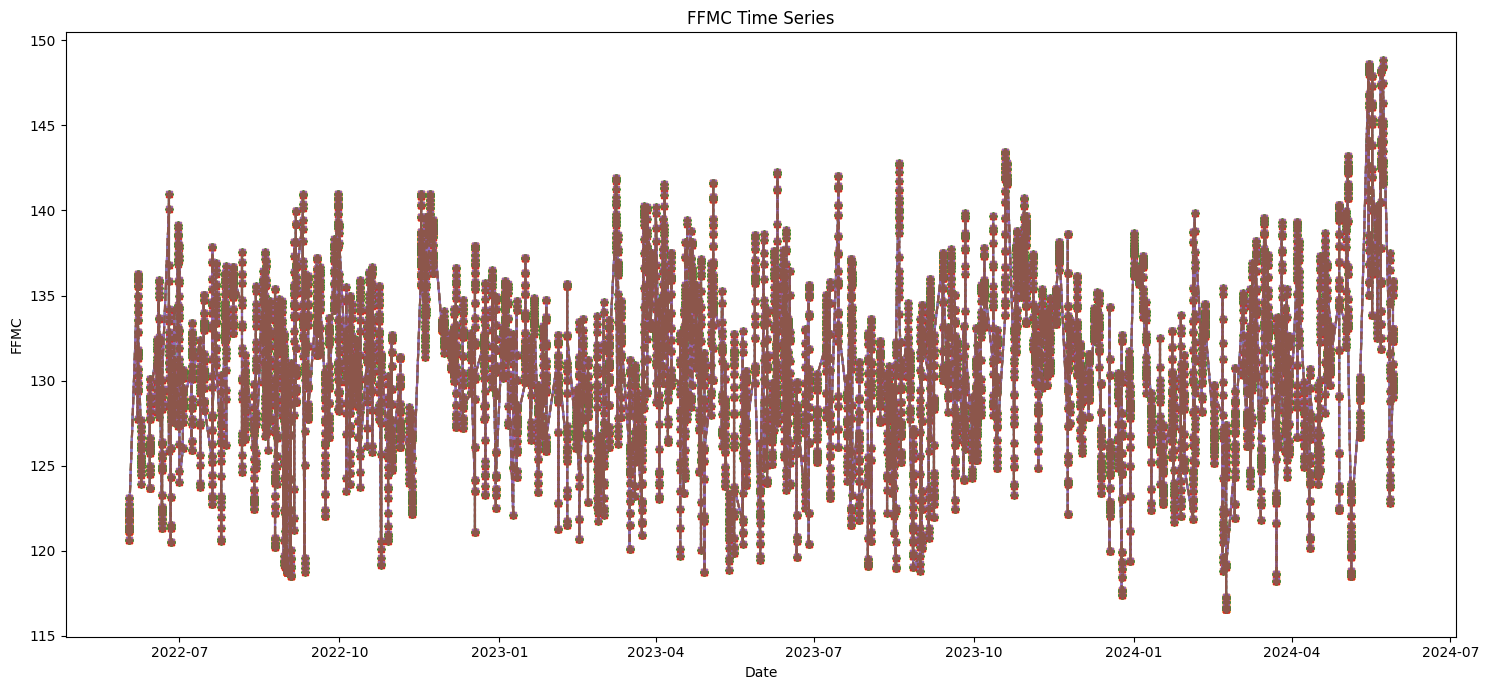

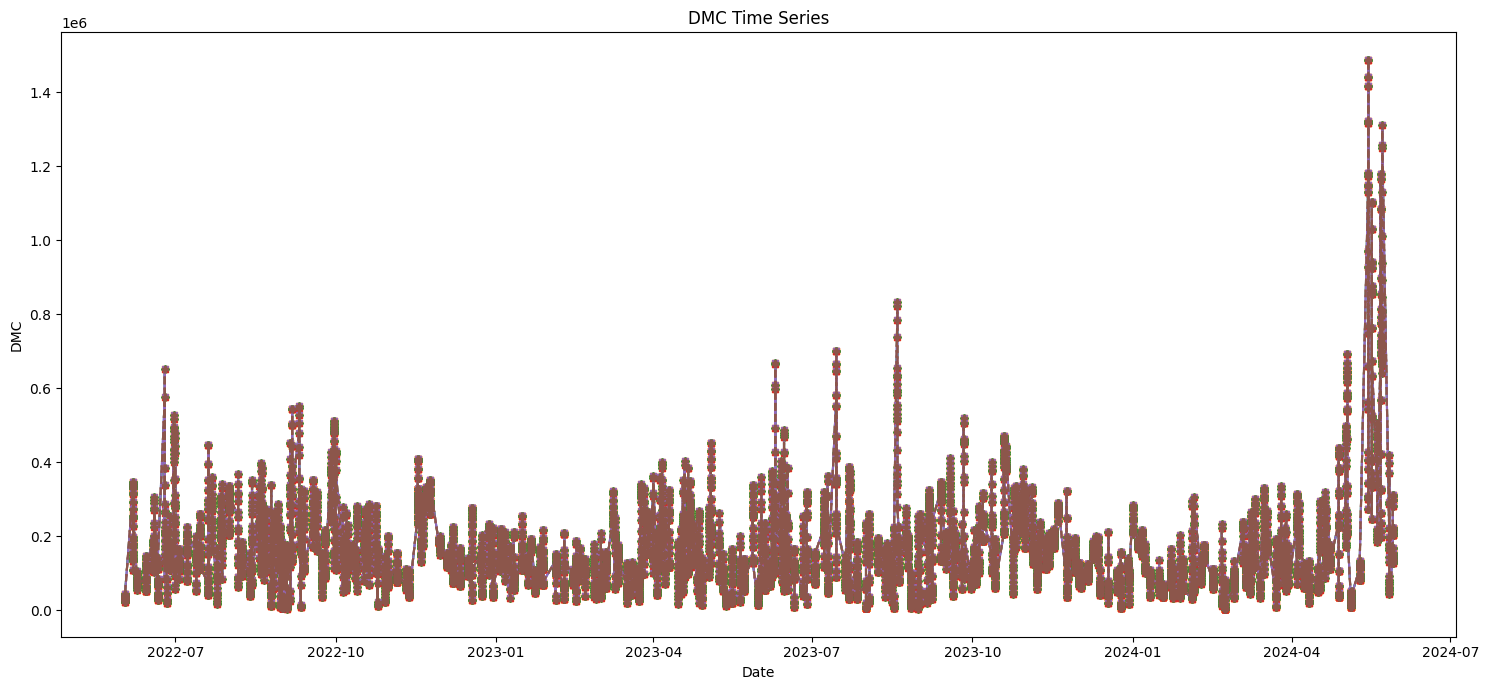

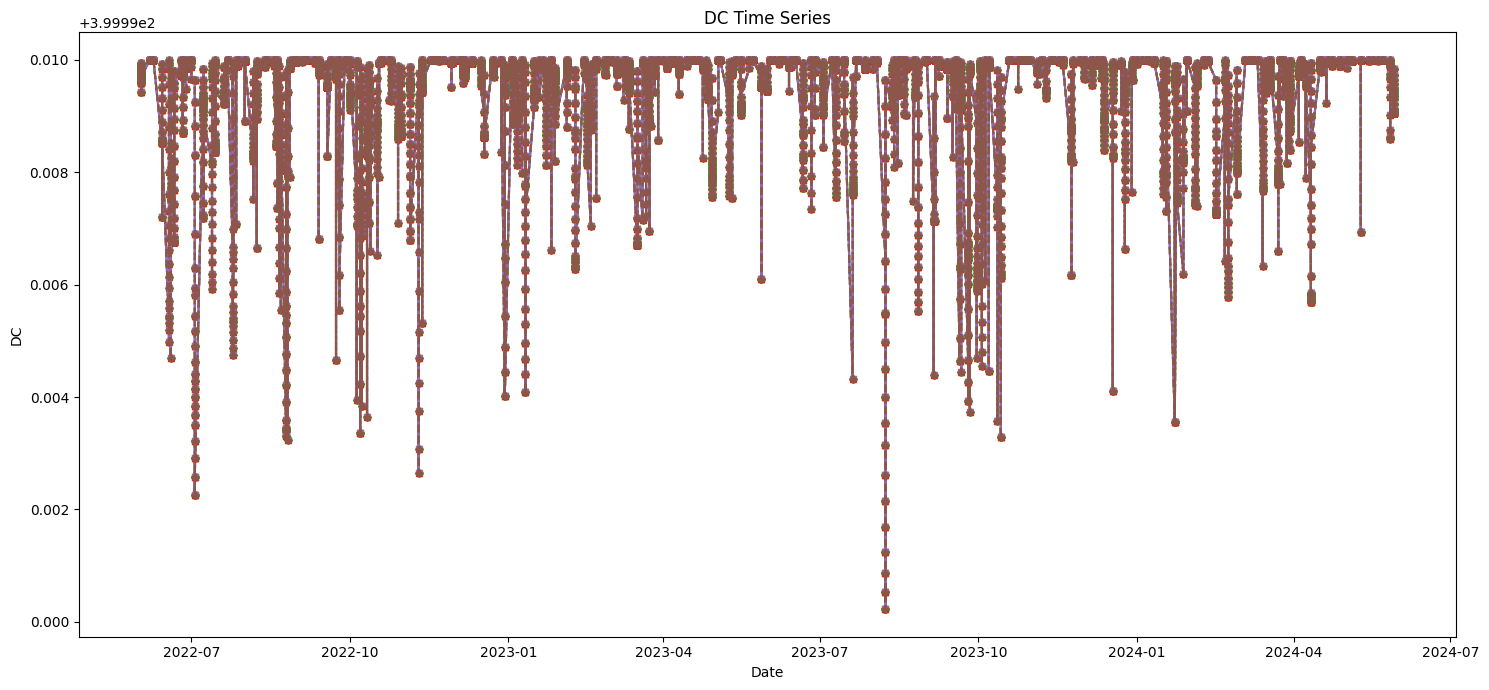

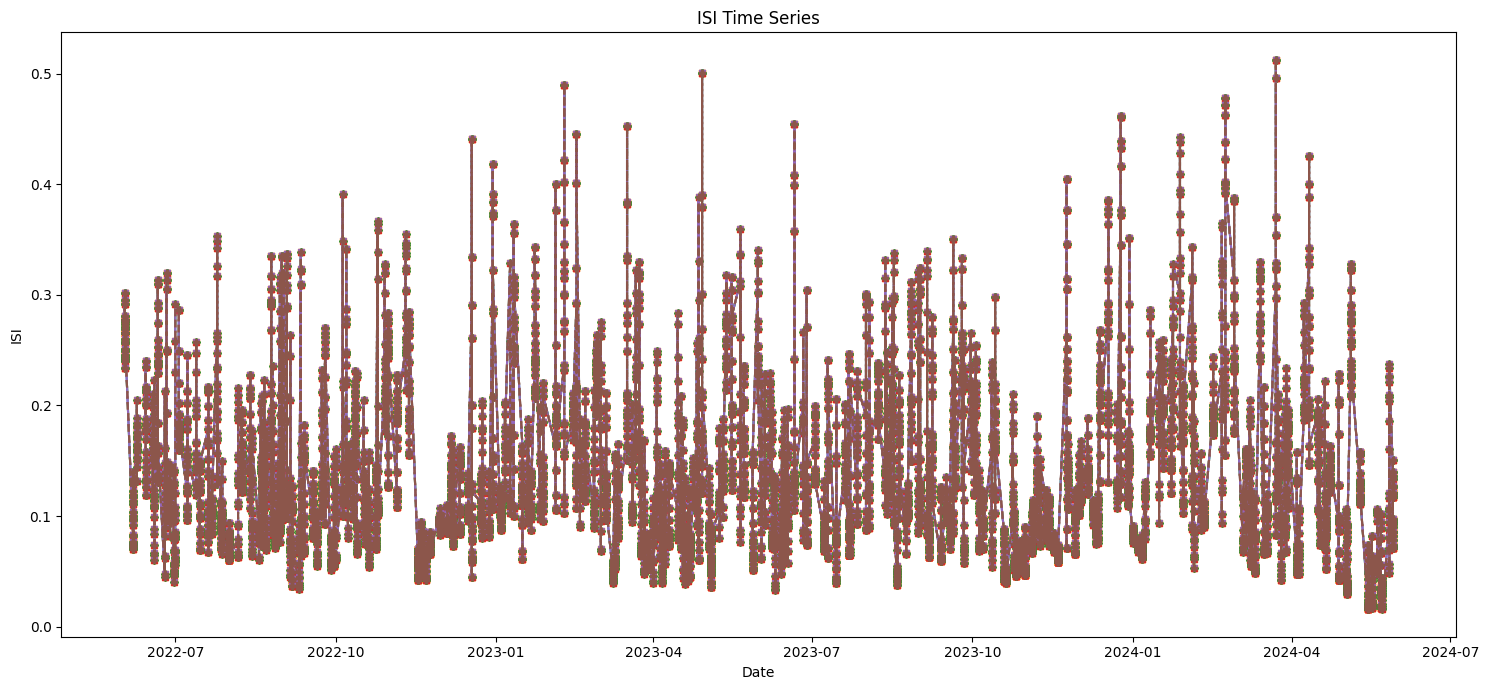

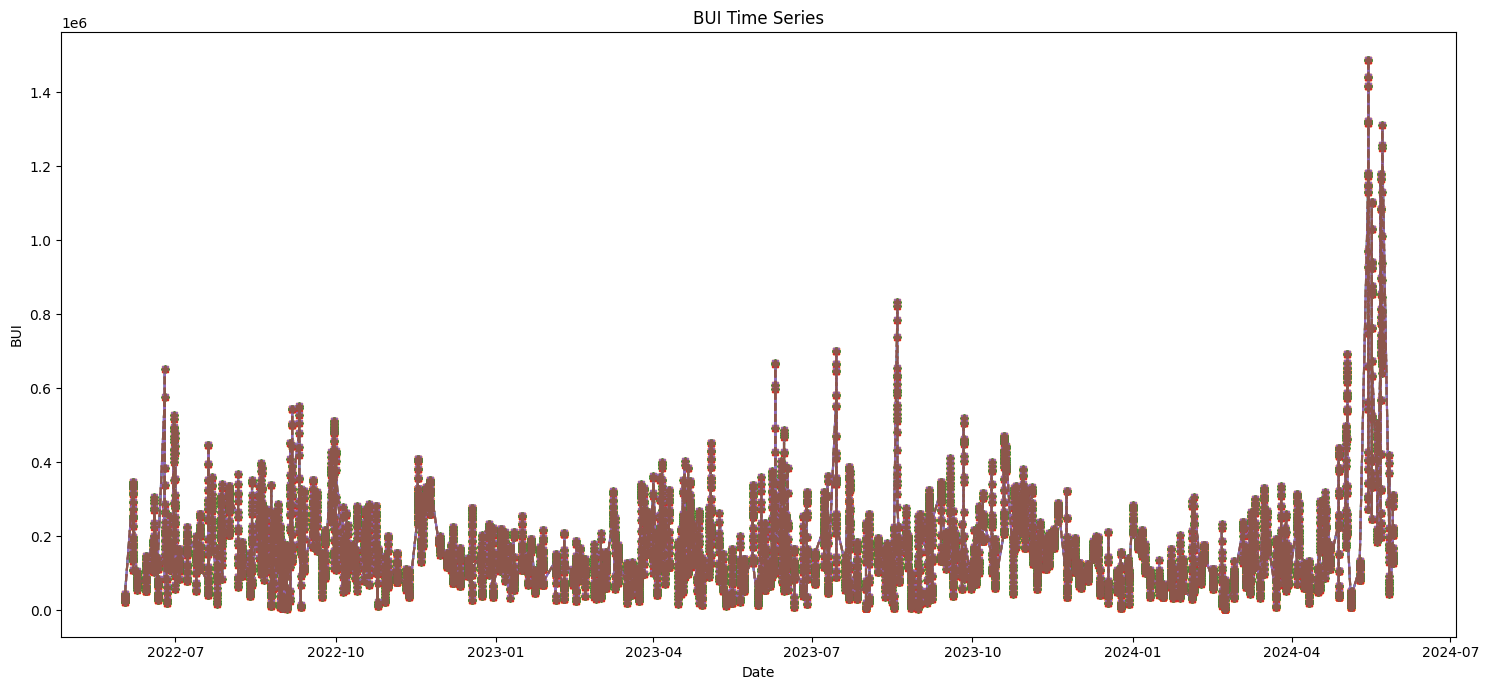

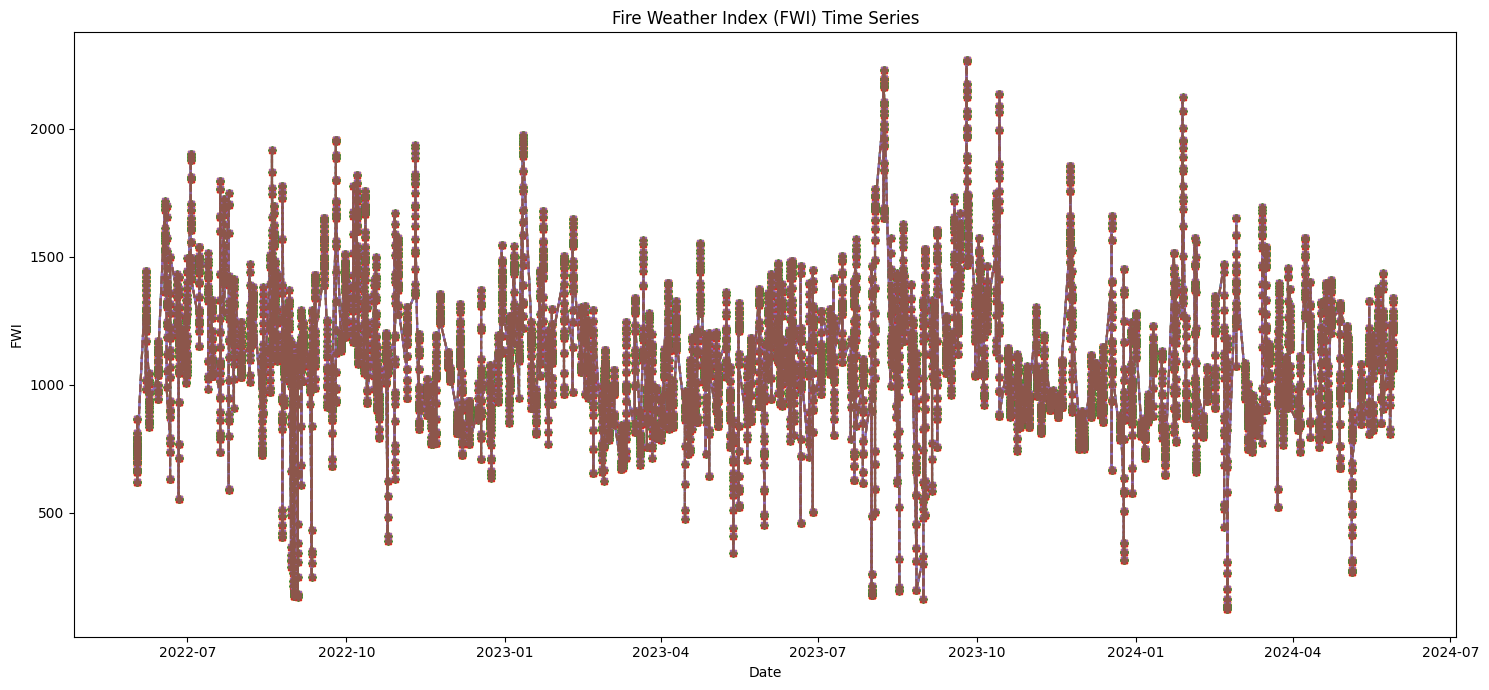

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simplified formulas for the sake of this example
def calculate_FFMC(T, RH, wind, rain):
    mo = 147.2 * (101.0 - 85.0) / (59.5 + 85.0)
    rf = rain - 0.5
    if mo > 0 and rf > 0:
        mo = mo + 42.5 * rf * np.exp(-100.0 / (251.0 - mo)) * (1.0 - np.exp(-6.93 / rf))
    ed = 0.942 * (RH ** 0.679) + 11.0 * np.exp((RH - 100.0) / 10.0) + 0.18 * (21.1 - T) * (1.0 - 1.0 / np.exp(0.115 * RH))
    ew = 0.618 * (RH ** 0.753) + 10.0 * np.exp((RH - 100.0) / 10.0) + 0.18 * (21.1 - T) * (1.0 - 1.0 / np.exp(0.115 * RH))
    if mo < ed:
        mo = ed - (ed - mo) / 10.0
    elif mo > ew:
        mo = ew + (mo - ew) / 10.0
    else:
        mo = mo
    FFMC = 59.5 * (250.0 - mo) / (147.2 + mo)
    return FFMC

def calculate_DMC(T, RH, rain, month):
    if rain > 1.5:
        rain = rain - 1.5
    else:
        rain = 0
    el = (0.36 * (T + 2.8) + np.exp((T + 2.8) / 17.27)) / 100
    DMC = el * (1.0 + (T - 4.5) / 50) * ((100 - RH) / 100) + rain
    return DMC

def calculate_DC(T, rain, month):
    if month > 5 and month < 9:
        k = 0.0005
    else:
        k = 0.0004
    DC = 400.0 * np.exp(-k * rain)
    return DC

def calculate_ISI(FFMC, wind):
    ISI = 0.208 * np.exp(0.05039 * wind) * (91.9 * np.exp(-0.1386 * FFMC) * (1.0 + FFMC ** 5.31 / 493000.0))
    return ISI

def calculate_BUI(DMC, DC):
    if DMC <= 0.4 * DC:
        BUI = 0.8 * DMC * DC / (DMC + 0.4 * DC)
    else:
        BUI = DMC - (1.0 - 0.8 * DC / (DMC + 0.4 * DC))
    return BUI

def calculate_FWI(ISI, BUI):
    if BUI <= 80.0:
        FWI = ISI * (0.1 * BUI)
    else:
        FWI = ISI * (0.626 * BUI ** 0.809 + 2.0)
    return FWI

# Ensure 'combined_df' contains 'RelativeHumidity' and 'WindSpeed' columns
# Add FFMC, DMC, DC, ISI, BUI, and FWI to the combined DataFrame
combined_df['FFMC'] = combined_df.apply(lambda row: calculate_FFMC(row['Temperature'], row['RelativeHumidity'], row['WindSpeed'], row['Precipitation']), axis=1)
combined_df['DMC'] = combined_df.apply(lambda row: calculate_DMC(row['Temperature'], row['RelativeHumidity'], row['Precipitation'], row['Date'].month), axis=1)
combined_df['DC'] = combined_df.apply(lambda row: calculate_DC(row['Temperature'], row['Precipitation'], row['Date'].month), axis=1)
combined_df['ISI'] = combined_df.apply(lambda row: calculate_ISI(row['FFMC'], row['WindSpeed']), axis=1)
combined_df['BUI'] = combined_df.apply(lambda row: calculate_BUI(row['DMC'], row['DC']), axis=1)
combined_df['FWI'] = combined_df.apply(lambda row: calculate_FWI(row['ISI'], row['BUI']), axis=1)

# Save the combined DataFrame with FWI to a CSV file
combined_df.to_csv('combined_timeseries_with_FWI.csv', index=False)

# Plot the components of FWI
components_to_plot = ['FFMC', 'DMC', 'DC', 'ISI', 'BUI']
for component in components_to_plot:
    fig, ax = plt.subplots(figsize=(15, 7))
    for i, shp in enumerate(shapefiles):
        shp_indices = combined_df[combined_df['Shapefile'] == shp]
        simple_name = shapefile_names[i]
        sorted_shp_indices = shp_indices.sort_values(by='Date')
        ax.plot(sorted_shp_indices['Date'], sorted_shp_indices[component], linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
    ax.set_title(f'{component} Time Series')
    ax.set_ylabel(component)
    ax.set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(os.path.join(plot_directory, f'{component}_Time_Series.png'))
    plt.show()

# Plot FWI time series for all shapefiles
fig, ax = plt.subplots(figsize=(15, 7))
for i, shp in enumerate(shapefiles):
    shp_indices = combined_df[combined_df['Shapefile'] == shp]
    simple_name = shapefile_names[i]
    sorted_shp_indices = shp_indices.sort_values(by='Date')
    ax.plot(sorted_shp_indices['Date'], sorted_shp_indices['FWI'], linestyle=line_styles[i % len(line_styles)], marker=markers[i % len(markers)], markersize=4)
ax.set_title('Fire Weather Index (FWI) Time Series')
ax.set_ylabel('FWI')
ax.set_xlabel('Date')
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'FWI_Time_Series_All_Shapefiles.png'))
plt.show()
